In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")

os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Airtel_Chatbot"

## Model

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

# model = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

n:\Coding\Projects\LangGraph_AirtelChatBot\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tools

In [4]:
from langchain_core.tools import tool

@tool("Network_Related_Issues",return_direct=True)
def tool_network_related_issues(text:str)->str:
    """
    If the issues are related to network connection, network speed, connection drops, 5G or any other network related issues, this tool will be used.
    This takes the text as input and returns the response for the network related issues.
    """
    return "Your Network has been optimized from our side.\n \
        If the issue persists, please book an apointment with the technician."

@tool("Plan_Queries",return_direct=True)
def tool_plan_queries(text:str)->str:
    """
    If the issues are related to the plan details,current plan, plan validity, plan charges or plan type, this tool will be used. This takes the text as input and returns the response for the plan related queries.
    """
    plan_details = {"Type":"Black","Charges":699,"Validity":"30 days"}
    return f"Your current plan is {plan_details['Type']} plan with charges of {plan_details['Charges']} and validity of {plan_details['Validity']}."

@tool("Recharge",return_direct=True)
def tool_recharge(text:str)->str:
    """
    If the issues are related to recharge this tool will be used. This takes the text as input and returns the response for the recharge related issues.
    """
    return "You can recharge your account through Airtel Thanks App."

tools = [
    tool_network_related_issues,
    tool_plan_queries,
    tool_recharge
]

In [5]:
model = model.bind_tools(tools)

## Agent State

In [6]:
from typing import TypedDict, Annotated
from langgraph.graph.message import AnyMessage, add_messages


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Nodes

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: AgentState):
        while True:
            state = {**state}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            # "You are a helpful customer support assistant for Airtel. "
            # " Use the provided tools to resolve network related queries, provide plan details, recharge details and other information to assist the user's queries. "
            # " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            # " If a search comes up empty, expand your search before giving up."
        ),
        ("placeholder", "{messages}"),
    ]
)

assistant_runnable = primary_assistant_prompt | model.bind_tools(tools)

## Graph

In [8]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition,ToolNode

builder = StateGraph(AgentState)


# Define nodes
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", ToolNode(tools))
# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

graph = builder.compile()

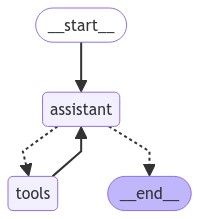

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

## Ultility Function

In [10]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

## Testing the inputs

In [11]:
tutorial_questions = [
    "My internet gets disconnected",
    "How to know my plan details and recharge.",
    "My internet speed is very less",
    "My network speed is very low",
    "What are my current plan details"
]
_printed = set()
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

My internet gets disconnected
================================== Ai Message ==================================
Tool Calls:
  Network_Related_Issues (544a6028-6838-4cfa-8b57-4377b8b81702)
 Call ID: 544a6028-6838-4cfa-8b57-4377b8b81702
  Args:
    text: My internet gets disconnected
================================= Tool Message =================================
Name: Network_Related_Issues

Your Network has been optimized from our side.
         If the issue persists, please book an apointment with the technician.
================================== Ai Message ==================================

Your Network has been optimized from our side. If the issue persists, please book an apointment with the technician.
================================ Human Message =================================

How to know my plan details and recharge.
================================== Ai Message ==============================